## **NOC Near-Present Day Hackathon - Day 1**
### Tutorial 2. Getting Started with NEMO Cookbook

#### **Contact:**
Ollie Tooth (oliver.tooth@noc.ac.uk)

#### **Background:**
---

NEMO Cookbook is a collection of recipes for performing reproducible analyses of the Nucleus for European Modelling of the Ocean ([**NEMO**](https://www.nemo-ocean.eu/)) ocean general circulation model outputs.

Each recipe in the NEMO Cookbook uses the `NEMODataTree` object to leverage [**xarray**](https://xarray.dev/), [**flox**](https://flox.readthedocs.io/en/latest/) & [**dask**](https://www.dask.org/) libraries to calculate a diagnostic with NEMO ocean model outputs.

In this second hands-on tutorial, we will use the `NEMODataTree` object to analyse outputs of the [**Near-Present-Day**](https://noc-msm.github.io/NOC_Near_Present_Day/) global ocean sea-ice simulations developed by the National Oceanography Centre as part of the Atlantic Climate and Environment Strategic Science ([**AtlantiS**](https://noc.ac.uk/projects/atlantis)) programme.

We will cover:

* How to create `NEMODataTree` objects directly from netCDF files and Near-Present-Day outputs stored in the JASMIN object store using the **OceanDataCatalog**.

* How to navigate and access NEMO output variables stored in a `NEMODataTree`.

* How to open and subset Analysis-Ready Cloud-Optimised ([**ARCO**](https://doi.org/10.1109/MCSE.2021.3059437)) datasets as lazy [**xarray**](https://docs.xarray.dev/en/stable/user-guide/data-structures.html) Datasets.

#### **2.1 Creating NEMODataTrees**
---

* Let's begin by importing the **NEMO Cookbook** Python library and the `NEMODataTree` class:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import nemo_cookbook as ncb
from nemo_cookbook import NEMODataTree

##### **2.1.1 Creating NEMODataTrees from Local Files**

* We'll begin by creating a simple `NEMODataTree` using local NEMO model output files from the `AGRIF_DEMO` reference configuration.

---

`AGRIF_DEMO`

* `AGRIF_DEMO` is based on the `ORCA2_ICE_PISCES` global reference configuration with the inclusion of 3 online nested domains.

* Here, we will only consider the 2° global parent domain.

* **NEMO Cookbook** includes a subset of the `AGRIF_DEMO` model outputs made accessible via cloud object storage.

* Further information on this reference configuration can be found [**here**](https://sites.nemo-ocean.io/user-guide/cfgs.html#agrif-demo).

---

* Let's download and collect the filepaths for the `AGRIF_DEMO` configuration using the `nemo_cookbook.examples.get_filepaths()` convenience function, which caches and generates local filepaths for available NEMO reference configurations:

In [2]:
filepaths = ncb.examples.get_filepaths("AGRIF_DEMO")
filepaths

{'domain_cfg.nc': '/Users/otooth/Library/Caches/nemo_cookbook/AGRIF_DEMO/domain_cfg.nc',
 '2_domain_cfg.nc': '/Users/otooth/Library/Caches/nemo_cookbook/AGRIF_DEMO/2_domain_cfg.nc',
 '3_domain_cfg.nc': '/Users/otooth/Library/Caches/nemo_cookbook/AGRIF_DEMO/3_domain_cfg.nc',
 'ORCA2_5d_00010101_00010110_grid_T.nc': '/Users/otooth/Library/Caches/nemo_cookbook/AGRIF_DEMO/ORCA2_5d_00010101_00010110_grid_T.nc',
 'ORCA2_5d_00010101_00010110_grid_U.nc': '/Users/otooth/Library/Caches/nemo_cookbook/AGRIF_DEMO/ORCA2_5d_00010101_00010110_grid_U.nc',
 'ORCA2_5d_00010101_00010110_grid_V.nc': '/Users/otooth/Library/Caches/nemo_cookbook/AGRIF_DEMO/ORCA2_5d_00010101_00010110_grid_V.nc',
 'ORCA2_5d_00010101_00010110_grid_W.nc': '/Users/otooth/Library/Caches/nemo_cookbook/AGRIF_DEMO/ORCA2_5d_00010101_00010110_grid_W.nc',
 'ORCA2_5d_00010101_00010110_icemod.nc': '/Users/otooth/Library/Caches/nemo_cookbook/AGRIF_DEMO/ORCA2_5d_00010101_00010110_icemod.nc',
 '2_Nordic_5d_00010101_00010110_grid_T.nc': '/User

* We can create a `NEMODataTree` from a dictionary of paths to local netCDF files using the `.from_paths()` constructor:

---

`from_paths()`

* Creates a `NEMODataTree` from a dictionary of paths to NEMO model outputs files organised into a hierarchy (e.g., `parent`, `child` `grandchild`) of NEMO model grids (e.g., `gridT`, `gridU`, etc.):
```
    <xarray.DataTree 'nemo'>
    Group: /
    ├── Group: /gridT
    ├── Group: /gridU
    ├── Group: /gridV
    ├── Group: /gridW
    └── Group: /gridF
```

where the `gridT` node contains time series of scalar variables stored in the `...grid_T.nc` files in a single `xarray.Dataset` and so on.

---

* Let's start by defining the `paths` dictionary, which contains the filepaths corresponding to our global parent domain.

* We populate the `parent` dictionary with the filepaths to the `domain_cfg` and `gridT/U/V/W` netCDF files produced for the `AGRIF_DEMO` (ORCA2) parent domain. 

In [3]:
paths = {"parent": {
         "domain": filepaths["domain_cfg.nc"],
         "gridT": filepaths["ORCA2_5d_00010101_00010110_grid_T.nc"],
         "gridU": filepaths["ORCA2_5d_00010101_00010110_grid_U.nc"],
         "gridV": filepaths["ORCA2_5d_00010101_00010110_grid_V.nc"],
         "gridW": filepaths["ORCA2_5d_00010101_00010110_grid_W.nc"],
         "icemod": filepaths["ORCA2_5d_00010101_00010110_icemod.nc"]
        },
        }

* We can now construct a new `NEMODataTree` called `nemo` using the `.from_paths()` constructor.

* **Note that we also need to specify that our global parent domain is zonally periodic (`iperio=True`) and north folding on T-points (`nftype = "T"`) rather than a closed (regional) domain.**

In [4]:
nemo = NEMODataTree.from_paths(paths, iperio=True, nftype="T")
nemo

<xarray.DataTree>
Group: /
│   Dimensions:               (time_counter: 2, axis_nbounds: 2, ncatice: 5)
│   Coordinates:
│     * time_counter          (time_counter) object 16B 0001-01-03 12:00:00 0001-...
│     * ncatice               (ncatice) float32 20B 1.0 2.0 3.0 4.0 5.0
│       time_centered         (time_counter) object 16B 0001-01-03 12:00:00 0001-...
│       time_instant          (time_counter) object 16B ...
│   Dimensions without coordinates: axis_nbounds
│   Data variables:
│       time_centered_bounds  (time_counter, axis_nbounds) object 32B 0001-01-01 ...
│       time_counter_bounds   (time_counter, axis_nbounds) object 32B 0001-01-01 ...
│       time_instant_bounds   (time_counter, axis_nbounds) object 32B ...
│   Attributes:
│       nftype:   T
│       iperio:   True
├── Group: /gridT
│       Dimensions:               (time_counter: 2, axis_nbounds: 2, j: 148, i: 180,
│                                  ncatice: 5, k: 31)
│       Coordinates:
│         * j                     (j) int64 1kB 1 2 3 4 5 6 ... 143 144 145 146 147 148
│         * i                     (i) int64 1kB 1 2 3 4 5 6 ... 175 176 177 178 179 180
│         * k                     (k) int64 248B 1 2 3 4 5 6 7 ... 25 26 27 28 29 30 31
│           time_centered         (time_counter) object 16B 0001-01-03 12:00:00 0001-...
│         * deptht                (k) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
│           time_instant          (time_counter) object 16B ...
│           gphit                 (j, i) float64 213kB ...
│           glamt                 (j, i) float64 213kB ...
│       Dimensions without coordinates: axis_nbounds
│       Data variables: (12/87)
│           time_centered_bounds  (time_counter, axis_nbounds) object 32B 0001-01-01 ...
│           time_counter_bounds   (time_counter, axis_nbounds) object 32B 0001-01-01 ...
│           simsk                 (time_counter, j, i) float32 213kB ...
│           simsk05               (time_counter, j, i) float32 213kB ...
│           simsk15               (time_counter, j, i) float32 213kB ...
│           snvolu                (time_counter, j, i) float32 213kB ...
│           ...                    ...
│           e1t                   (j, i) float64 213kB ...
│           e2t                   (j, i) float64 213kB ...
│           top_level             (j, i) int32 107kB ...
│           bottom_level          (j, i) int32 107kB ...
│           tmask                 (k, j, i) bool 826kB False False False ... False False
│           tmaskutil             (j, i) bool 27kB False False False ... False False
│       Attributes:
│           name:         ORCA2_5d_00010101_00010110_icemod
│           description:  ice variables
│           title:        ice variables
│           Conventions:  CF-1.6
│           timeStamp:    2025-Sep-13 17:44:13 GMT
│           uuid:         c6c24bd5-1d2b-4d7b-98b5-8d379c94e84b
│           nftype:       T
│           iperio:       True
├── Group: /gridU
│       Dimensions:               (k: 31, axis_nbounds: 2, time_counter: 2, j: 148,
│                                  i: 180)
│       Coordinates:
│         * k                     (k) int64 248B 1 2 3 4 5 6 7 ... 25 26 27 28 29 30 31
│         * j                     (j) int64 1kB 1 2 3 4 5 6 ... 143 144 145 146 147 148
│         * i                     (i) float64 1kB 1.5 2.5 3.5 4.5 ... 178.5 179.5 180.5
│         * depthu                (k) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
│           time_centered         (time_counter) object 16B ...
│           time_instant          (time_counter) object 16B ...
│           gphiu                 (j, i) float64 213kB ...
│           glamu                 (j, i) float64 213kB ...
│       Dimensions without coordinates: axis_nbounds
│       Data variables: (12/15)
│           depthu_bounds         (k, axis_nbounds) float32 248B ...
│           time_centered_bounds  (time_counter, axis_nbounds) object 32B ...
│           time_counter_bounds   (time_coun

##### **2.1.2 Creating NEMODataTrees from Datasets**

* We can alternatively create a `NEMODataTree` from a dictionary of `xarray.Datasets` using the `.from_datasets()` constructor:

---

`from_datasets()`

* Creates a `NEMODataTree` from a dictionary of `xarray.Datasets` organised into a hierarchy (e.g., `parent`, `child` `grandchild`) of NEMO model grids (e.g., `gridT`, `gridU`, etc.):

```
    <xarray.DataTree 'nemo'>
    Group: /
    ├── Group: /gridT
    ├── Group: /gridU
    ├── Group: /gridV
    ├── Group: /gridW
    └── Group: /gridF
```

where the `gridT` node contains time series of scalar variables stored in the input `xarray.Dataset` and so on.

---

* Before defining the `datasets` dictionary, which contains the `xarray.Datasets` corresponding to our global parent domain, we first use the **OceanDataCatalog** to access the monthly mean outputs of the 1° NPD eORCA1 ERA5v1 simulation.

* For simplicity, we'll only populate the `datasets` dictionary with the `xarray.Datasets` associated with T (scalar) and icemod (sea ice) grid points, alongside the required domain_cfg. 

**Note that we will still obtain a `NEMODataTree` with a complete set of grid nodes (i.e., `gridT`, `gridU`, etc.)**

In [ ]:
from OceanDataStore import OceanDataCatalog

# Initialising the OceanDataCatalog using the `noc-model-stac` stored in the JASMIN cloud object store:
catalog = OceanDataCatalog(catalog_name="noc-model-stac")

# Alternative: Initialising the OceanDataCatalog using the `noc-model-stac` stored locally:
# catalog = OceanDataCatalog(catalog_url="/groups/npd-workshop/noc-model-stac/catalog.json")

In [6]:
# Open eORCA1 ERA5 v1 domain_cfg ancillary dataset:
ds_domain_cfg = catalog.open_dataset(id="noc-npd-era5/npd-eorca1-era5v1/gn/domain/domain_cfg")
# Open eORCA1 ERA5 v1 T-grid dataset:
ds_gridT = catalog.open_dataset(id="noc-npd-era5/npd-eorca1-era5v1/gn/T1m")
# Open eORCA1 ERA5 v1 V-grid dataset:
ds_gridV = catalog.open_dataset(id="noc-npd-era5/npd-eorca1-era5v1/gn/V1m")
# Open eORCA1 ERA5 v1 icemod dataset:
ds_icemod = catalog.open_dataset(id="noc-npd-era5/npd-eorca1-era5v1/gn/I1m")

ds_gridT

  2026-01-16T14:16:18.491119Z  WARN aws_config::imds::region: failed to load region from IMDS, err: failed to load IMDS session token: dispatch failure: io error: client error (Connect): tcp connect error: Host is down (os error 64) (FailedToLoadToken(FailedToLoadToken { source: DispatchFailure(DispatchFailure { source: ConnectorError { kind: Io, source: hyper_util::client::legacy::Error(Connect, ConnectError("tcp connect error", 169.254.169.254:80, Os { code: 64, kind: Uncategorized, message: "Host is down" })), connection: Unknown } }) }))
    at /Users/runner/miniforge3/conda-bld/icechunk_1767037408716/_build_env/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/aws-config-1.8.12/src/imds/region.rs:66

  2026-01-16T14:16:20.218456Z  WARN aws_config::imds::region: failed to load region from IMDS, err: failed to load IMDS session token: dispatch failure: io error: client error (Connect): tcp connect error: Host is down (os error 64) (FailedToLoadToken(FailedToLoadToken { source: Di

<xarray.Dataset> Size: 482GB
Dimensions:                (time_counter: 595, y: 331, x: 360, deptht: 75,
                            axis_nbounds: 2)
Coordinates:
  * time_counter           (time_counter) datetime64[ns] 5kB 1976-01-16T12:00...
  * deptht                 (deptht) float32 300B 0.5058 1.556 ... 5.902e+03
    nav_lat                (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon                (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_centered          (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/74)
    berg_latent_heat_flux  (time_counter, y, x) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    empmr                  (time_counter, y, x) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    ficeberg               (time_counter, y, x) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    hfds                   (time_counter, y, x) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    fsitherm               (time_counter, y, x) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    evs                    (time_counter, y, x) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    ...                     ...
    tossq_con              (time_counter, y, x) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    ttrd_qns_li            (time_counter, y, x) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    zos                    (time_counter, y, x) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    ttrd_evd_li            (time_counter, deptht, y, x) float32 21GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
    zossq                  (time_counter, y, x) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    vowflisf               (time_counter, deptht, y, x) float32 21GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>

In [7]:
ds_domain_cfg

<xarray.Dataset> Size: 710MB
Dimensions:       (y: 331, x: 360, nav_lev: 75)
Coordinates:
  * y             (y) int64 3kB 0 1 2 3 4 5 6 7 ... 324 325 326 327 328 329 330
  * x             (x) int64 3kB 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * nav_lev       (nav_lev) int64 600B 0 1 2 3 4 5 6 7 ... 68 69 70 71 72 73 74
Data variables: (12/49)
    bathy_metry   (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    atlmsk        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    bottom_level  (y, x) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    e2u           (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    e1f           (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    e1v           (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    ...            ...
    top_level     (y, x) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    umask         (nav_lev, y, x) int8 9MB dask.array<chunksize=(75, 331, 360), meta=np.ndarray>
    umaskutil     (y, x) int8 119kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    vmask         (nav_lev, y, x) int8 9MB dask.array<chunksize=(75, 331, 360), meta=np.ndarray>
    vmaskutil     (y, x) int8 119kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    wmask         (nav_lev, y, x) bool 9MB dask.array<chunksize=(75, 331, 360), meta=np.ndarray>
Attributes:
    CfgName:    UNKNOWN
    CfgIndex:   -999
    Iperio:     1
    Jperio:     0
    NFold:      1
    NFtype:     F
    VertCoord:  zps
    IsfCav:     0
    file_name:  mesh_mask.nc
    TimeStamp:  01/03/2025 22:19:49 -0000

In [8]:
datasets = {"parent": {"domain": ds_domain_cfg, "gridT": ds_gridT, "gridV": ds_gridV, "icemod": ds_icemod}}

In [9]:
nemo_npd = NEMODataTree.from_datasets(datasets=datasets, iperio=True, nftype="F")

nemo_npd

<xarray.DataTree>
Group: /
│   Dimensions:               (time_counter: 595, axis_nbounds: 2, ncatice: 5)
│   Coordinates:
│     * time_counter          (time_counter) datetime64[ns] 5kB 1976-01-16T12:00:...
│     * ncatice               (ncatice) float32 20B 1.0 2.0 3.0 4.0 5.0
│       time_centered         (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
│   Dimensions without coordinates: axis_nbounds
│   Data variables:
│       time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 10kB dask.array<chunksize=(1, 2), meta=np.ndarray>
│       time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] 10kB dask.array<chunksize=(1, 2), meta=np.ndarray>
│   Attributes:
│       nftype:   F
│       iperio:   True
├── Group: /gridT
│       Dimensions:                (time_counter: 595, j: 331, i: 360, ncatice: 5,
│                                   axis_nbounds: 2, k: 75)
│       Coordinates:
│         * j                      (j) int64 3kB 1 2 3 4 5 6 ... 326 327 328 329 330 331
│         * i                      (i) int64 3kB 1 2 3 4 5 6 ... 355 356 357 358 359 360
│         * k                      (k) int64 600B 1 2 3 4 5 6 7 ... 69 70 71 72 73 74 75
│           time_centered          (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
│         * deptht                 (k) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
│           gphit                  (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamt                  (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│       Dimensions without coordinates: axis_nbounds
│       Data variables: (12/132)
│           albedo                 (time_counter, j, i) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           hfxsensib              (time_counter, j, i) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           isig1                  (time_counter, j, i) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           isig2                  (time_counter, j, i) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           hfxcndbot              (time_counter, j, i) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           hfxcndtop              (time_counter, j, i) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
│           ...                     ...
│           e1t                    (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2t                    (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           top_level              (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           bottom_level           (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           tmask                  (k, j, i) bool 9MB False False False ... False False
│           tmaskutil              (j, i) bool 119kB False False False ... False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridU
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│         * j             (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i             (i) float64 3kB 1.5 2.5 3.5 4.5 ... 357.5 358.5 359.5 360.5
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│           gphiu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│       Data variables:
│           e1u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           umask         (k, j, i) bool 9MB False False False ... False False 

#### **2.2 Navigating NEMODataTrees**
---

* Now we have created two example `NEMODataTrees`, let's take a closer look at their contents and how to access NEMO model output variables.

* We'll start by looking at the nodes in our `NEMODataTree`:

In [10]:
nemo_npd.groups

('/', '/gridT', '/gridU', '/gridV', '/gridW', '/gridF')

**Some Important Points:**

* `NEMODataTree` does not have a `domain` node since grid scale factors and masks associated with each model domain are assigned to their respective grid nodes during pre-processing (e.g., horizontal grid scale factors `e1t` and `e2t` are stored in `/gridT` etc.).

* During the construction of a `NEMODataTree`, the standard (`depth{p}`, `y`, `x`) dimensions of NEMO model outputs (where `p` is the grid point type) are transformed to NEMO grid indices (**i**, **j**, **k**). This has two important implications:

    * `xarray.Datasets` stored in each grid node share the same coordinate dimension names (`i`, `j`, `k`), but are staggered according to the location of variables on the NEMO model grid.

    * All grid indices use Fortran (1-based) indexing to be consistent with the original NEMO model code.

* To see what this means in practice, we will consider the `gridT` and `gridU` nodes of the 1° NPD eORCA1 ERA5v1 `NEMODataTree` below:

In [11]:
nemo_npd['gridT']

<xarray.DataTree 'gridT'>
Group: /gridT
    Dimensions:                (time_counter: 595, axis_nbounds: 2, ncatice: 5,
                                j: 331, i: 360, k: 75)
    Coordinates:
      * j                      (j) int64 3kB 1 2 3 4 5 6 ... 326 327 328 329 330 331
      * i                      (i) int64 3kB 1 2 3 4 5 6 ... 355 356 357 358 359 360
      * k                      (k) int64 600B 1 2 3 4 5 6 7 ... 69 70 71 72 73 74 75
        time_centered          (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
      * deptht                 (k) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
        gphit                  (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
        glamt                  (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    Inherited coordinates:
      * ncatice                (ncatice) float32 20B 1.0 2.0 3.0 4.0 5.0
      * time_counter           (time_counter) datetime64[ns] 5kB 1976-01-16T12:00...
    Dimensions without coordinates: axis_nbounds
    Data variables: (12/132)
        albedo                 (time_counter, j, i) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
        hfxsensib              (time_counter, j, i) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
        isig1                  (time_counter, j, i) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
        isig2                  (time_counter, j, i) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
        hfxcndbot              (time_counter, j, i) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
        hfxcndtop              (time_counter, j, i) float32 284MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
        ...                     ...
        e1t                    (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
        e2t                    (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
        top_level              (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
        bottom_level           (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
        tmask                  (k, j, i) bool 9MB False False False ... False False
        tmaskutil              (j, i) bool 119kB False False False ... False False
    Attributes:
        nftype:   F
        iperio:   True

In [12]:
nemo_npd['gridU']

<xarray.DataTree 'gridU'>
Group: /gridU
    Dimensions:       (time_counter: 595, axis_nbounds: 2, ncatice: 5, j: 331,
                       i: 360, k: 75)
    Coordinates:
      * j             (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
      * i             (i) float64 3kB 1.5 2.5 3.5 4.5 ... 357.5 358.5 359.5 360.5
      * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
        gphiu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
        glamu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    Inherited coordinates:
      * ncatice       (ncatice) float32 20B 1.0 2.0 3.0 4.0 5.0
      * time_counter  (time_counter) datetime64[ns] 5kB 1976-01-16T12:00:00 ... 2...
    Dimensions without coordinates: axis_nbounds
    Data variables:
        e1u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
        e2u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
        umask         (k, j, i) bool 9MB False False False ... False False False
        umaskutil     (j, i) bool 119kB False False False ... False False False
    Attributes:
        nftype:   F
        iperio:   True

* Above, we have seen how to access the nodes in an `NEMODataTree` using a dictionary-like syntax.

* We can also extend this to include output variables stored in given grid node as follows...

* To access an **unmasked** (i.e., unchanged from the original model output files) variable as an `xarray.DataArray`:

In [13]:
nemo_npd['gridT']['tos_con']

<xarray.DataArray 'tos_con' (time_counter: 595, j: 331, i: 360)> Size: 284MB
dask.array<open_dataset-tos_con, shape=(595, 331, 360), dtype=float32, chunksize=(1, 331, 360), chunktype=numpy.ndarray>
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 5kB 1976-01-16T12:00:00 ... ...
  * j              (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
  * i              (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
    time_centered  (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
    gphit          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    glamt          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
Attributes:
    standard_name:       sea_surface_temperature
    long_name:           sea_surface_conservative_temperature
    units:               degC
    online_operation:    average
    interval_operation:  3600 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 3600 s)

* To access a **masked** (i.e., the appropriate land-sea mask is applied automatically) variable as an `xarray.DataArray`, we can instead provide a direct path to the variable:

In [14]:
nemo_npd["gridT/tos_con"]

<xarray.DataArray 'tos_con' (time_counter: 595, j: 331, i: 360)> Size: 284MB
dask.array<where, shape=(595, 331, 360), dtype=float32, chunksize=(1, 331, 360), chunktype=numpy.ndarray>
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 5kB 1976-01-16T12:00:00 ... ...
  * j              (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
  * i              (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
    time_centered  (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
    gphit          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    glamt          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
Attributes:
    standard_name:       sea_surface_temperature
    long_name:           sea_surface_conservative_temperature
    units:               degC
    online_operation:    average
    interval_operation:  3600 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 3600 s)

#### **2.3 NEMODataTree Grid Properties**
---

* In Tutorial 1, we showed that we often need access to variables describing the NEMO ocean model domain to calculate derived quantities, such as volume, heat and salt transports.

* For convenience, the `NEMODataTree` class includes methods for calculating grid cell areas and volumes.

* For example, to compute the horizontal area of grid cells centered on T-points in the parent domain, we can use the `.cell_area()` method:

---

`cell_area()`

* The `dim` argument represents the dimensional orthogonal to the grid cell area to be computed.

* For **T** grid points, this results in the following grid cell areas: 

    | dim   | Grid Cell Area           |
    | ----------- | ---------------------- |
    | `i`         | e2t * e3t             |
    | `j`         | e1t * e3t        |
    | `k`         | e1t * e2t        |

---

In [15]:
nemo_npd.cell_area(grid="gridT", dim="k")

<xarray.DataArray 'areacello' (j: 331, i: 360)> Size: 953kB
dask.array<mul, shape=(331, 360), dtype=float64, chunksize=(331, 360), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 3kB 1 2 3 4 5 6 7 8 9 ... 324 325 326 327 328 329 330 331
  * i        (i) int64 3kB 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
    gphit    (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    glamt    (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>

* Next, let's compute the volume of each grid cell centered on a T grid point in the model parent domain using the `.cell_volume()` method:

In [16]:
nemo_npd.cell_volume(grid="gridT")

<xarray.DataArray 'volcello' (time_counter: 595, k: 75, j: 331, i: 360)> Size: 43GB
dask.array<mul, shape=(595, 75, 331, 360), dtype=float64, chunksize=(1, 25, 331, 360), chunktype=numpy.ndarray>
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 5kB 1976-01-16T12:00:00 ... ...
  * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
  * j              (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
  * i              (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
    time_centered  (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
  * deptht         (k) float32 300B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    gphit          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    glamt          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
Attributes:
    standard_name:       cell_thickness
    long_name:           T-cell thickness
    units:               m
    online_operation:    average
    interval_operation:  3600 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 3600 s)

#### **2.5 Core Operations**
---

* In addition to simply storing ocean model outputs in a hierarchical data structure, a `NEMODataTree` also enables us to perform scalar (e.g., gradient) and vector (e.g., divergence, curl) operations as formulated in NEMO.

---

**Examples**

* `.gradient(dom, var, dim)` - Compute the gradient of a scalar variable `var` along one of the horizontal dimensions (e.g., `i`, `j`) of a given NEMO model domain `dom`.

* `.divergence(dom, vars)` - Compute the horizontal divergence from the `i` and `j` components of a vector field (e.g., `uo`, `vo`) of a given NEMO model domain `dom`.

* `.curl(dom, vars)` - Compute the vertical component of the curl of a horizontal vector field (e.g., `uo`, `vo`) of a given NEMO model domain `dom`.

* For more details on the above core operations see the follow section of the [**How To... Guide**](https://noc-msm.github.io/nemo_cookbook/howto/#calculate-horizontal-gradients).

---

* Here, we will focus on the `.integral()` method, which can be used to integrate a variable `var` along one or more dimensions `dims` of a given NEMO model grid `grid`.

* Let's revisit our Northern Hemisphere sea ice area calculation from Tutorial 1...


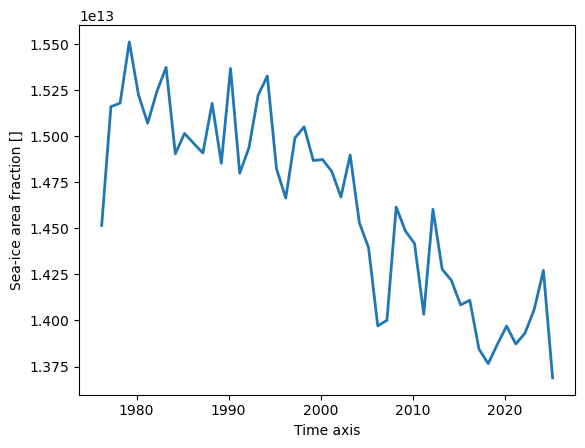

In [17]:
# Define mask for Northern Hemisphere T-points using the gphit (latitude) variable.
NH_mask = nemo_npd['gridT/gphit'] > 0

(nemo_npd
  # Select only March sea ice concentration data.
  .sel(time_counter=nemo_npd['gridT']['time_counter'].dt.month.isin([3]))
  # Calculate area integral of sea ice concentration (fraction, 0-1).
  .integral(grid='gridT', var='siconc', dims=['i', 'j'], mask=NH_mask)
  # Plot the resulting time series.
  .plot(lw=2)
)

* We can also use the `.integral()` method to calculate cumulative integrals along one or more dimensions of a given NEMO model grid.

* For more details on cumulative integration see the following section of the [**How To... Guide**](https://noc-msm.github.io/nemo_cookbook/howto/#calculate-cumulative-integrals).

#### **2.6 Grid Transformations**
---

* Given that scalar and vector NEMO output variables are not co-located on the model grid, we often need to transform a variable defined on a given NEMO horizontal grid to a neighbouring grid via linear interpolation.

* For example, we can transform conservative temperature `thetao_con` defined on scalar **T**-points to neighbouring **V**-points in a NEMO model parent domain using the `.transform_to()` method:

In [18]:
nemo_npd.transform_to(grid='gridT', var='thetao_con', to='V')

<xarray.DataArray 'thetao_con' (time_counter: 595, k: 75, j: 331, i: 360)> Size: 43GB
dask.array<where, shape=(595, 75, 331, 360), dtype=float64, chunksize=(1, 25, 331, 360), chunktype=numpy.ndarray>
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 5kB 1976-01-16T12:00:00 ... ...
  * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
  * j              (j) float64 3kB 1.5 2.5 3.5 4.5 ... 328.5 329.5 330.5 331.5
  * i              (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
    time_centered  (time_counter) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
  * depthv         (k) float32 300B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    gphiv          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    glamv          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
Attributes:
    standard_name:       sea_water_conservative_temperature
    long_name:           sea_water_conservative_temperature
    units:               degC
    online_operation:    average
    interval_operation:  1 month
    interval_write:      1 month
    cell_methods:        time: mean

**Note that the original T-grid coordinate variables have been replaced by those of the V-grid onto which the conservative temperature field has been linearly interpolated.**

* We can also transform a variable defined on a given NEMO model vertical grid to a new vertical grid using conservative interpolation via the `.transform_vertical_grid()` method.

* For more details on vertical grid transformations see the following section of the [**How To... Guide**](https://noc-msm.github.io/nemo_cookbook/howto/#transform-variable-to-a-neighbouring-horizontal-grid).

#### **2.7 Grid-Aware Statistics**
---

* In a typical ocean data analysis worflow, we are interested in performing grid-aware diagnostics for a chosen geographical region within our NEMO model domain.

* `NEMODataTree` therefore provides several methods to create regional masks and compute aggregated statistics considering only grid cells within a given geographical region.

* We can define a regional mask using the geographical coordinates of a closed polygon using the `.mask_with_polygon()` method:

In [19]:
# Open IHO World Seas v2 polygons from JASMIN Object Store as Pandas DataFrame:
filepaths = ncb.examples.get_filepaths("IHO")

df_IHO_World_Seas = pd.read_parquet(filepaths['IHO_World_Seas_v3_polygons.parquet'])
df_IHO_World_Seas

,ID,Name,MRGID,Longitudes,Latitudes
0,0,Rio de La Plata,4325,"[[-54.943023652717045, -54.978746687192626, -5...","[[-34.947906883078645, -34.97439280639835, -35..."
1,1,Bass Strait,4366,"[[149.90464234356938, 149.9049998519617, 149.9...","[[-37.54324781853184, -37.54805552943908, -37...."
2,2,Great Australian Bight,4276,"[[143.53250818354263, 143.54855731580784, 143....","[[-38.855345058560204, -38.89580867390668, -38..."
3,3,Tasman Sea,4365,"[[159.03333000000018, 159.03983414634163, 159....","[[-29.999999999999986, -30.043495934959335, -3..."
4,4,Mozambique Channel,4261,"[[43.38217926066437, 43.426910578414024, 43.47...","[[-11.370205640977488, -11.374667237992885, -1..."
...,...,...,...,...,...
96,96,Laccadive Sea,4269,"[[79.19056582495296, 79.20560240772511, 79.205...","[[9.28162992038466, 9.280296445224849, 9.28018..."
97,97,Skagerrak,2379,"[[10.66160702664314, 10.662945270907699, 10.66...","[[59.91287636715083, 59.910394549469004, 59.90..."
98,98,Norwegian Sea,2353,"[[16.72106314339885, 16.78890655530549, 16.856...","[[76.5645473926769, 76.50603497544391, 76.4475..."
99,99,Ligurian Sea,3363,"[[9.834412487214706, 9.835301503777828, 9.8349...","[[44.0485148685363, 44.04729517147973, 44.0472..."


/var/folders/z2/j_dr250s42x34hk63_rp4bm80000gq/T/ipykernel_40493/1157022198.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(nemo_npd['gridT']['glamt'], nemo_npd['gridT']['gphit'], nemo_npd['gridT']['tos_con'].where(mask).mean(dim='time_counter'), cmap='RdBu_r')


(45.0, 65.0)

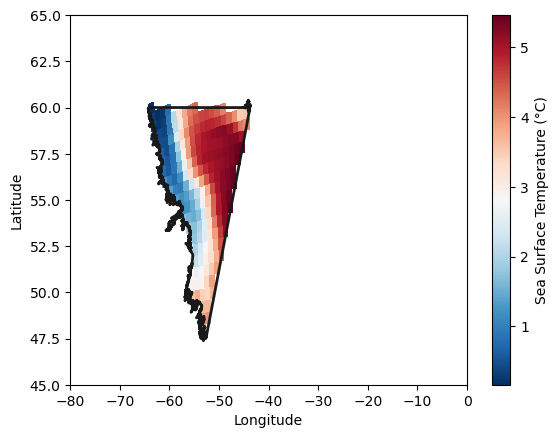

In [20]:
# Define IHO World Seas Labrador Sea polygon:
lon_poly = df_IHO_World_Seas[df_IHO_World_Seas['Name'] == 'Labrador Sea']['Longitudes'].item()[0]
lat_poly = df_IHO_World_Seas[df_IHO_World_Seas['Name'] == 'Labrador Sea']['Latitudes'].item()[0]

# Define boolean mask for Labrador Sea:
mask = nemo_npd.mask_with_polygon(grid='gridT', lon_poly=lon_poly, lat_poly=lat_poly)

# Plotting Labrador Sea sub-domain:
plt.figure()
plt.pcolormesh(nemo_npd['gridT']['glamt'], nemo_npd['gridT']['gphit'], nemo_npd['gridT']['tos_con'].where(mask).mean(dim='time_counter'), cmap='RdBu_r')
plt.plot(lon_poly, lat_poly, color='0.1', lw=2)
plt.colorbar(label='Sea Surface Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-80, 0])
plt.ylim([45, 65])


Text(0, 0.5, 'Sea Surface Temperature (°C)')

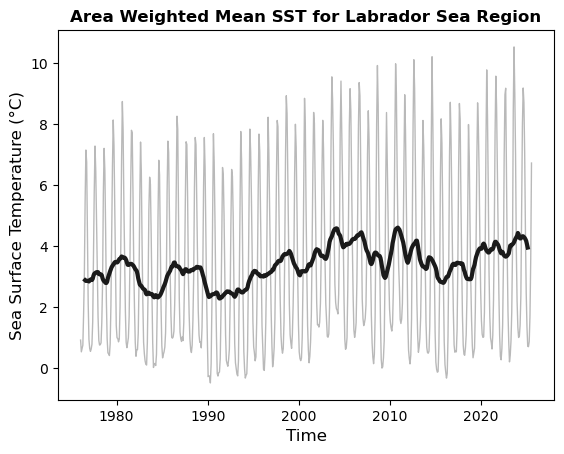

In [21]:
# Calculating the area weighted-mean sea surface temperature in the SPG region:
sst_wmean = nemo_npd.masked_statistic(grid="gridT",
                                      var="tos_con",
                                      lon_poly=lon_poly,
                                      lat_poly=lat_poly,
                                      statistic="weighted_mean",
                                      dims=["i", "j"]
                                      )

# Plotting the area weighted-mean sea surface temperature time series for the Labrador Sea region:
sst_wmean.plot(lw=1, color='0.1', alpha=0.3)
sst_wmean.rolling(time_counter=12, center=True).mean().plot(lw=3, color='0.1')
plt.title('Area Weighted Mean SST for Labrador Sea Region', fontsize=12, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sea Surface Temperature (°C)', fontsize=12)